In [1]:
import mdtraj as md
import glob as glob
from scipy import spatial
from collections import defaultdict
from tqdm import tqdm_notebook
import numpy as np
import os

In [21]:
def hydrophicity_clusterer(files, threshold=0.5, interchain=True, intraresidue=False, 
                           hydrophobicity_map=None, h_threshold=0.0, debug=True):
    
    """
    Function to calculate the number of contacts each residue has hydrophobic and hydrophilic residues.
    As a convention values above h_threshold are considered hydrophobic and others hydrophilic.
    
    v0.1: First version, based on clusterer
   
    :type threshold: float
    :type interchain: bool
    :type intraresidue: bool
    :hydrophobicity_map: dict
    :h_threshold: float
    :type debug: bool
    
    :param directory: files to run calculation
    :param threshold: threshold in nm in contact definition
    :param interchain: whether to look at interchain contacts
    :param intraresidue: whether to look for interactions within the same residue
    :param debug: switch on debug mode
    :param hydrophobicity_map: dictionary with hydrophobicity scores
    :param h_threshold: hydrohobicity threshold
    
    :rtype: dict
    :return: a dict with dictionaries with the contacts for each each residue.
             Each position has a list with two entries:
             - element 0: is there a hydrophilic contact
             - element 1: is there a hydrophobic contact
    
    Pseudocode:
    ----------
        1. for each file in directory:
            a. Read PDB to extract residue names
            b. Parse file with mdtraj
            c. initialise contacts dict
            d. Calculate dense matrix with euclidean distances and then convert to squareform
            f. for each position below threshold:
                i. Find out position of corresponding atom
               ii. Find out if it is hydrophobic or hydrophilic and store in 2 dimensional vector
        2. Return dict (with key corresponding to file) with contacts of each file
    """
    
    if hydrophobicity_map is None:
        raise ValueError("Unspecified hydrophobicity map!")
        
    if len(hydrophobicity_map) != 20:
        raise ValueError("hydrophobicity_map requires 20 keys, one for each amino acid!")
        
    result = dict()
    
    for file in tqdm_notebook(files):
        
        file_name = os.path.split(file)[-1].split('.')[0] # get file basename
                
        seq=list()

        atom_map = dict()

        with open(file, 'r') as f:
            file_length = 0
            i=0
            for line in f.readlines():

                line_el = line.split()


                if len(line_el) < 6:
                    continue

                try:
                    if line_el[2] not in ['N', 'O', 'CA', 'C']:
                        file_length += 1
                        atom_map[i] = (line_el[4], line_el[5], line_el[3])
                        i+=1

                    if (line_el[4], line_el[5]) not in seq:
                        seq.append((line_el[4], line_el[5]))
                except:
                    raise ValueError(line)

        result_i = dict()

        model = md.load_pdb(file)

        model = model.atom_slice(model.top.select('all and sidechain'))

        atoms = model.n_atoms

        contacts = defaultdict(lambda: [0, 0])

        dists = spatial.distance.pdist(model.xyz.squeeze(0))

        dist_threshold = np.where(spatial.distance.squareform(dists) < threshold)

        for atom1, atom2 in zip(dist_threshold[0], dist_threshold[1]):

            position1 = atom_map[atom1][0]+atom_map[atom1][1]
            position2 = atom_map[atom2][0]+atom_map[atom2][1]
            
            if not interchain and position1[0] != position2[0]:
                # if atoms are in different chains skip
                continue
                
            if not intraresidue and position1 == position2:
                # skip if atoms are in same residue
                continue
                
            if not isinstance(position1, str) or not isinstance(position2, str):
                # skip position to handle errors
                continue
            if hydrophobicity_map[atom_map[atom1][-1]] <= h_threshold:
                contacts[position1][0] += 1
            else:
                contacts[position1][1] += 1
                
        for position in contacts:
            contact = contacts[position]
            
            total = sum(contact)
            
            if total > 0:
                contacts[position][0] = contacts[position][0] / total
                contacts[position][1] = contacts[position][1] / total
        
        result[file_name] = contacts
                
    return result

In [22]:
def parse_hydrophobicity(file):
    
    scores = dict()
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('!'):
                continue
                
            el = line.split()
            if len(el) > 1:
            
                scores[el[0]] = float(el[1])
            
    return scores

In [23]:
consensus_H = parse_hydrophobicity('../Hydrophobicity/data/consensus.hpb')

In [24]:
files = glob.glob('../models/*pdb')
result = hydrophicity_clusterer(files, 1, hydrophobicity_map=consensus_H, h_threshold=0,debug=False)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [31]:
import json

with open('/home/gil/AbPyTools/abpytools/data/NumberingSchemes.json') as f:
    data = json.load(f)['chothia']
    heavy_data = data['heavy']
    light_data = data['light']
    
    numbering_data = [*heavy_data, *light_data]

In [32]:
def vector_representation(data, order):
    """
    Function to represent cluster data in matrix form
    
    :type data: dict
    
    :param data: data from clusterer
    
    :rtype: dict
    :return: returns dict with same keys as data containing a dict 
             with the vector for each position
             
    Explanation:
    ------------
    
    Each vector has the following order:
    
    [hydrophobic_contact, hydrophilic_contact]
    
    Each elemeent either takes up the value of 0 (no contact) or 1 (contact)
    
    """
    
    result = dict()
    
    for key, value in tqdm_notebook(data.items()):
        
        file_result = dict()
        
        for pos in order:
            
            file_result[pos] = value[pos]
            
        result[key] = file_result
                
    return result

In [33]:
result_matrix = vector_representation(result, numbering_data)

HBox(children=(IntProgress(value=0, max=900), HTML(value='')))

In [35]:
import pandas as pd

In [36]:
hydrophobicity_pd = pd.DataFrame(result_matrix).T

In [38]:
hydrophobicity_pd.head()

,H1,H10,H100,H100A,H100B,H100C,H100D,H100E,H100F,H100G,...,L95A,L95B,L95C,L95D,L95E,L95F,L96,L97,L98,L99
P1,"[1.0, 0.0]","[1.0, 0.0]","[0, 0]","[0.0, 1.0]","[0.0, 1.0]","[1.0, 0.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1.0, 0.0]","[1.0, 0.0]","[0.0, 1.0]","[0, 0]"
P10,"[0, 0]","[1.0, 0.0]","[1.0, 0.0]","[0.0, 1.0]","[1.0, 0.0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0.0, 1.0]","[1.0, 0.0]","[0.0, 1.0]","[0, 0]"
P100,"[1.0, 0.0]","[0, 0]","[0.0, 1.0]","[1.0, 0.0]","[1.0, 0.0]","[1.0, 0.0]","[0.0, 1.0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1.0, 0.0]","[1.0, 0.0]","[0.0, 1.0]","[0, 0]"
P101,"[1.0, 0.0]","[0, 0]","[1.0, 0.0]","[0.0, 1.0]","[0.0, 1.0]","[0.0, 1.0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0.0, 1.0]","[1.0, 0.0]","[0.0, 1.0]","[0, 0]"
P102,"[0, 0]","[1.0, 0.0]","[0.0, 1.0]","[0.0, 1.0]","[1.0, 0.0]","[0.0, 1.0]","[0.0, 1.0]","[1.0, 0.0]","[1.0, 0.0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[1.0, 0.0]","[1.0, 0.0]","[0.0, 1.0]","[0, 0]"


In [39]:
hydrophobicity_pd = hydrophobicity_pd.applymap(lambda x: x[0])

In [42]:
from sklearn.decomposition import PCA, TruncatedSVD
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")

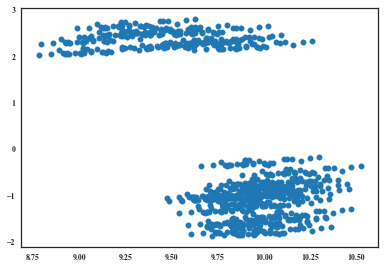

In [43]:
svd = TruncatedSVD()
reduced = svd.fit_transform(hydrophobicity_pd.as_matrix())
plt.scatter(reduced[:,0], reduced[:,1])